# Forecasting solar energy based on historical weather data

### Model Building by [Saurav Thakur](st23588@essex.ac.uk) for coursework project of Data Science and Decision Making (CE888)

- [Weather Documentation Link](https://www.visualcrossing.com/resources/documentation/weather-data/weather-data-documentation/)


# Introduction

The [problem statement](../2023_24_CE888_Project_Energy.pdf) is to build a model which can predict solar or wind energy atleast 24 hours in advance such that if there will be sulprus amount of energy, the company can send out an alert to customer in the particular area so that the customers can opt in a slot. Here the company is actually worried about the false positives, which means if there is no sulpurs amount of energy and if the company provides free electricity to the customers then the company will have to bear a huge cost. 

So the main aim of this project is to predict the solar energy atleast 24 hours in advance keeping in mind about the false positives.

In this project we will follow an end to end life cycle of a data science project. Data science life cycle consists of:

1. Understanding the problem.
2. Gathering the relevant data.
3. Data Preparation
4. Exploratory Data Analysis (EDA)
4. Feature Engineering and Feature Extraction
5. Model Building

In this notebook we will go through the preprocessing and model building process.

## Table of Contents

 1. [Introduction](#introduction)
 2. [Importing Libraries](#importing-libraries)
 3. [Loading the dataset](#loading-the-dataset)
 4. [Preprocessing Data](#preprocessing-data)
    - [Feature Selection](#feature-selection)
    - [Imputing Missing Values](#imputing-missing-values)
    - [Saving Preprocessed Files](#saving-the-preprocessed-file)
    - [Importing the Preprocessed Files](#importing-the-preprocessed-file)
    
 5. [Feature Engineering](#feature-engineering)
    - [Creating Lag Features](#creating-lag-features)
    - [Imputing Nulls Created by lags](#imputing-nulls-created-by-lags)

 6. [Choosing Threshold for Solarenergy](#choosing-threshold-for-solarenergy)
    - [Converting Solar Energy from MJ/m2 to KW](#converting-solar-energy-from-mjm2-to-kw)
 7. [Model Building](#model-building)
    - [Data Standardization](#data-standardization)
    - [Preparing Data For Training](#preparing-data-for-for-training)
    - [Metrics](#metrics)
    - [Naive Model](#naive-model)
    - [LSTM](#lstm)
    - [Prediction on Test](#prediction-on-test)
    - [Convering Prediction to Dataframe](#converting-predictions-to-dataframe-to-visualize)
    - [False Positives for initial threshold](#false-positives-for-initial-threshold)
    - [Threshold Updation](#threshold-updation)
    - [False Positives for safe buffer threshold](#false-positives-for-safe-buffer-threshold)
    - [Forecasting 24 hours in Advance](#forecasting-24-hours-in-advance)
    - [Making DataFrame to Visualize 24 hour Advance Forecast](#making-dataframe-to-visualize-24-hours-in-advance-forecast)
    - [Plots](#plots)
      - [Plots for Naive Model](#plot-for-naive-model)
      - [Plots for LSTM Model](#plot-for-lstm-model)

   

A Library to impute values for our dataset.

In [1]:
!pip install fancyimpute

# Importing Libraries

In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fancyimpute import KNN

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
from keras.callbacks import EarlyStopping
from collections import defaultdict


plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings("ignore")

# Loading the dataset

Loading the dataset which was splitted in the first part of the assignment.

In [2]:
train_data = pd.read_csv("../dataset/train/train_data.csv")
validation_data = pd.read_csv("../dataset/validation/validation_data.csv")
test_data = pd.read_csv("../dataset/test/test_data.csv")

In [6]:
train_data.tail()

,datetime,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,year
148314,2018-12-31 19:00:00,8.4,5.8,83.84,0.0,0.0,NaN,0.0,0.0,13.5,271.0,1034.2,100.0,0.0,0.0,0.0,2018
148315,2018-12-31 20:00:00,8.3,5.7,83.53,0.0,0.0,NaN,0.0,0.0,14.5,281.0,1034.3,100.0,0.0,0.0,0.0,2018
148316,2018-12-31 21:00:00,8.3,5.4,81.84,0.0,0.0,NaN,0.0,0.0,16.0,284.0,1034.1,100.0,0.0,0.0,0.0,2018
148317,2018-12-31 22:00:00,8.3,5.6,83.24,0.0,0.0,NaN,0.0,0.0,13.3,281.0,1033.9,100.0,0.0,0.0,0.0,2018
148318,2018-12-31 23:00:00,8.1,5.5,83.76,0.0,0.0,NaN,0.0,0.0,15.5,277.0,1033.4,100.0,0.0,0.0,0.0,2018


In [5]:
validation_data.head()

,datetime,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,year
0,2019-01-01 00:00:00,8.3,5.2,80.70,0.0,0.0,NaN,0.0,0.0,17.3,282.0,1033.3,100.0,0.0,0.0,0.0,2019
1,2019-01-01 01:00:00,8.2,5.0,80.49,0.0,0.0,NaN,0.0,0.0,17.3,294.0,1033.2,100.0,0.0,0.0,0.0,2019
2,2019-01-01 02:00:00,7.8,4.6,79.88,0.0,0.0,NaN,0.0,0.0,17.2,291.0,1033.0,85.3,0.0,0.0,NaN,2019
3,2019-01-01 03:00:00,7.4,4.6,82.26,0.0,0.0,NaN,0.0,0.0,15.9,283.0,1033.0,76.5,0.0,0.0,0.0,2019
4,2019-01-01 04:00:00,7.0,4.4,83.54,0.0,0.0,NaN,0.0,0.0,16.1,276.0,1032.8,48.0,0.0,0.0,0.0,2019


In [7]:
test_data.tail()

,datetime,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,year
22133,2024-01-05 05:00:00,5.2,4.1,92.17,NaN,0.0,NaN,NaN,NaN,27.6,325.0,993.2,100.0,0.0,0.0,0.0,2024
22134,2024-01-05 06:00:00,5.2,4.0,92.40,NaN,0.0,NaN,NaN,NaN,29.6,317.0,993.5,96.6,0.0,0.0,0.0,2024
22135,2024-01-05 07:00:00,5.5,4.0,89.64,NaN,0.0,NaN,NaN,NaN,28.1,308.0,994.5,95.8,0.0,0.0,0.0,2024
22136,2024-01-05 08:00:00,5.8,4.1,88.93,NaN,0.0,NaN,NaN,NaN,27.9,313.0,996.1,91.8,0.0,0.0,0.0,2024
22137,2024-01-05 09:00:00,6.0,4.2,88.83,NaN,0.0,NaN,NaN,NaN,27.5,311.0,996.9,92.3,8.0,0.0,0.0,2024


# Preprocessing Data

### Feature Selection

**In my previous assignment I had provided this documentation for feature selection. I have provided from where and how I have researched about the features.**

For feature selection the refernces that were taken are:

1. [Link 1](https://formesolar.com/how-wind-affects-solar-panels/)

2. [Link 2](https://www.solar.com/learn/how-do-wind-and-humidity-affect-solar-panel-efficiency/)

3. [Link 3](https://ae-solar.com/wind-effect-on-solar-panels/#:~:text=Wind%20speed%20has%20little%20influence,can%20increase%20just%20PV%20efficiency.)

Before predicting our values, let's decide which features to use for our model. Since we are forcasting solarenergy the important feature will be:

1. Temperature - If temperature is high means we are getting sunlight so we get high solar power.

2. Humidity - Like sweat beads, water vapor, or microscopic droplets of water, can collect on solar panels and reflect or refract sunlight away from solar cells. Because of this, they receive less sunlight, which produces less power. So this might provide our model some insight. [Link](https://www.solar.com/learn/how-do-wind-and-humidity-affect-solar-panel-efficiency/)

3. CloudCover - Cloudcover can imapct highly on solar power generation. If the cloud is covered it won't help panels to generate energy.

4. Solarradiation - If the solarradiation is low then energy is less generated and if the radiation is high then the energy generated is high as well.

5. UVIndex - uv rays also affect the generation of solarenergy. More the uv index higher the generation of the solar power.

6. Windspeed - windspeed helps solarpanel to remain cool and when panels are cooler they are efficient. Reference - [Link](https://ae-solar.com/wind-effect-on-solar-panels/)

7. Dew - The dew present on the solar panels can also negatively affect the production of solar energy. **Reference Research Paper** - [Link](https://www.seas.ucla.edu/~pilon/Publications/SOLMAT2021-effect%20of%20droplets%20on%20solar%20cells.pdf)



In [17]:
def preprocess_train_val_test_dataset(train_data,validation_data,test_data):

    # makes a copy of train, test and validation data so that it does not directly make changes into train data.
	train_data = train_data.copy()
	validation_data = validation_data.copy()
	test_data = test_data.copy()

    # takes train data from 2010 and onwards. 
	train_data = train_data[~train_data["year"].isin(np.arange(2000,2010,1))]
	
    # converts train val and test data datetime column to datetime
	train_data["datetime"] = pd.to_datetime(train_data["datetime"])
	validation_data["datetime"] = pd.to_datetime(validation_data["datetime"])
	test_data["datetime"] = pd.to_datetime(test_data["datetime"])
	
    # setting the datetime column as index
	train_data.set_index("datetime",inplace=True)
	validation_data.set_index("datetime",inplace=True)
	test_data.set_index("datetime",inplace=True)
	
    # selecting the features which we will use for training.
	train_data = train_data[["temp","humidity","cloudcover","solarradiation","solarenergy","uvindex","windspeed","dew"]]
	validation_data = validation_data[["temp","humidity","cloudcover","solarradiation","solarenergy","uvindex","windspeed","dew"]]
	test_data = test_data[["temp","humidity","cloudcover","solarradiation","solarenergy","uvindex","windspeed","dew"]]

	return train_data, validation_data, test_data

In [18]:
# calling the above function to preprocess the data
df,validation_data_df,test_data_df = preprocess_train_val_test_dataset(train_data,validation_data,test_data)

In [19]:
df.isnull().sum().index

Index(['temp', 'humidity', 'cloudcover', 'solarradiation', 'solarenergy',
       'uvindex', 'windspeed', 'dew'],
      dtype='object')

In [20]:
df

,temp,humidity,cloudcover,solarradiation,solarenergy,uvindex,windspeed,dew
datetime,,,,,,,,
2010-01-01 00:00:00,0.5,95.56,28.9,NaN,NaN,NaN,19.0,-0.2
2010-01-01 01:00:00,0.3,93.41,33.8,NaN,NaN,NaN,13.5,-0.6
2010-01-01 02:00:00,0.2,92.79,42.1,NaN,NaN,NaN,14.3,-0.8
2010-01-01 03:00:00,-0.1,95.73,68.5,NaN,NaN,NaN,11.4,-0.7
2010-01-01 04:00:00,-1.2,95.70,19.2,NaN,NaN,NaN,13.6,-1.8
...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,8.4,83.84,100.0,0.0,0.0,0.0,13.5,5.8
2018-12-31 20:00:00,8.3,83.53,100.0,0.0,0.0,0.0,14.5,5.7
2018-12-31 21:00:00,8.3,81.84,100.0,0.0,0.0,0.0,16.0,5.4


### Imputing Missing Values

To impute the values KNN imputer from library called fancyimpute has been used. KNN Imputer from SKlearn was also explored. But fancyimpute KNN performed better in terms of producing the model results. So fancy impute KNN was used to impute the values.

**Note: KNN from fancyimpute do not have transform method implementation so fit_transform method has been used for imputing the values of train, validation and test. Also this KNN Impute may use huge amount of RAM resources. So I will be attaching the preprocessed data so that this code will not have to run again**

In [60]:
def imputing_missing_values(data):
    
    data = data.copy()

    # KNN Imputer object
    imputer = KNN(k=5,
    orientation='rows',
    print_interval=10000)

    # imputing the values
    imputed_df = imputer.fit_transform(data) 
    
    return imputed_df

**Note: You dont have to run the below code again. It will take time to run this and may use huge part of RAM. I have attached the preprocessed code**

In [61]:
# df_imputed_check = imputing_missing_values(df)
# val_imputed_check = imputing_missing_values(validation_data_df)
# test_imputed_check = imputing_missing_values(test_data_df)


# df_imputed_check = pd.DataFrame(data=df_imputed_check,columns=df.columns,index=df.index)
# val_imputed_check = pd.DataFrame(data=val_imputed_check,columns=validation_data_df.columns,index=validation_data_df.index)
# test_imputed_check = pd.DataFrame(data=test_imputed_check,columns=test_data_df.columns,index=test_data_df.index)

Imputing row 1/66408 with 3 missing, elapsed time: 434.010
Imputing row 10001/66408 with 4 missing, elapsed time: 438.262
Imputing row 20001/66408 with 0 missing, elapsed time: 443.312
Imputing row 30001/66408 with 0 missing, elapsed time: 443.374
Imputing row 40001/66408 with 0 missing, elapsed time: 444.369
Imputing row 50001/66408 with 0 missing, elapsed time: 444.433
Imputing row 60001/66408 with 0 missing, elapsed time: 444.497


### Saving the Preprocessed File

In [67]:
def save_preprocessed(df_imputed_check,val_imputed_check,test_imputed_check):
    # # setting the index as datetime
    df_imputed_check.set_index(df.index,inplace=True)
    val_imputed_check.set_index(validation_data_df.index,inplace=True)
    test_imputed_check.set_index(test_data_df.index,inplace=True)
    
    df_imputed_check.to_csv("../dataset/train_preprocessed.csv",index=True)
    val_imputed_check.to_csv("../dataset/validation_preprocessed.csv",index=True)
    test_imputed_check.to_csv("../dataset/test_preprocessed.csv",index=True)

# save_preprocessed(df_imputed_check,val_imputed_check,test_imputed_check)

### Importing the preprocessed file

In [28]:
train_data_original = pd.read_csv("../dataset/train_preprocessed.csv",index_col="datetime")
validation_data_original = pd.read_csv("../dataset/validation_preprocessed.csv",index_col="datetime")
test_data_original = pd.read_csv("../dataset/test_preprocessed.csv",index_col="datetime")

train_data_original.index = pd.to_datetime(train_data_original.index)
validation_data_original.index = pd.to_datetime(validation_data_original.index)
test_data_original.index = pd.to_datetime(test_data_original.index)

In [ ]:
def plot_original_vs_imputed(feature1,feature2,feature1_title,feature2_title):

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

    ax1.plot(feature1,color="gray")
    ax2.plot(feature2,color="green")

    ax1.set_title(feature1_title)
    ax2.set_title(feature2_title)

    plt.tight_layout()

    plt.show()

Let's now plot and see how the values are imputed in the data using our imputer

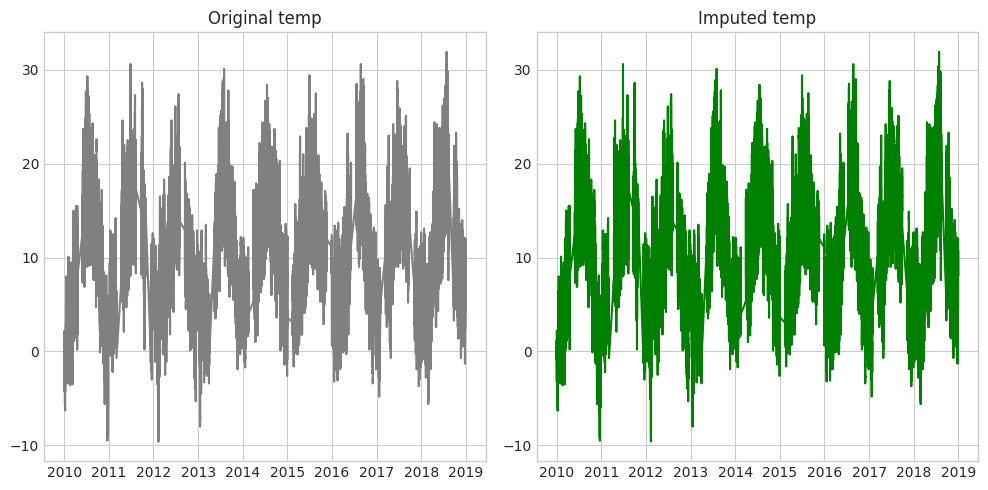

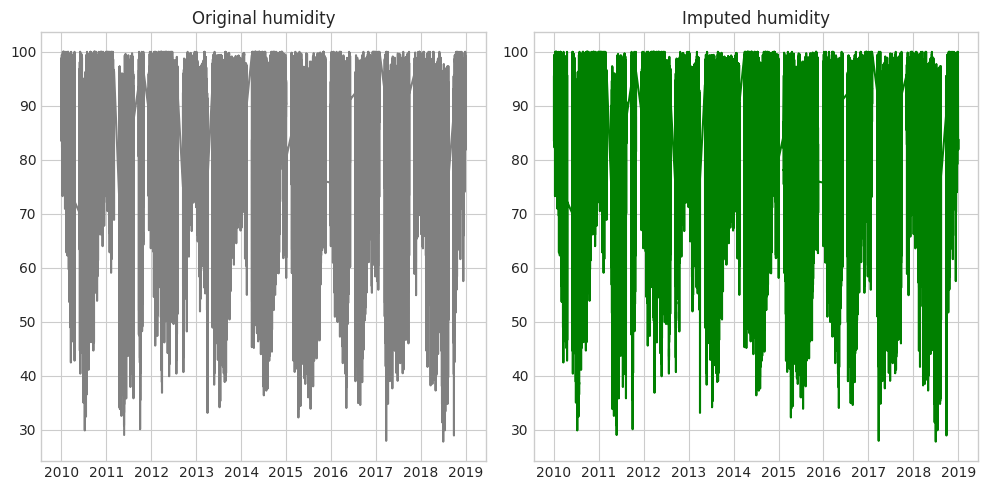

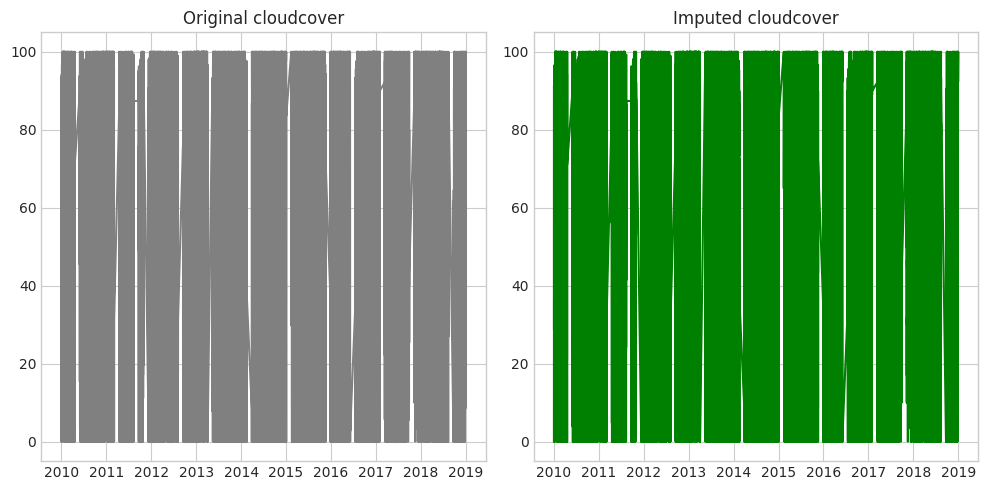

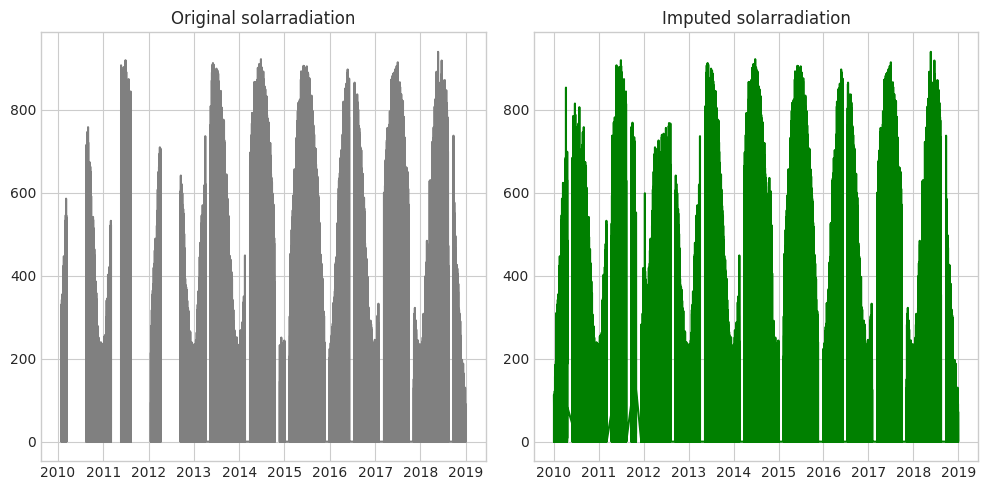

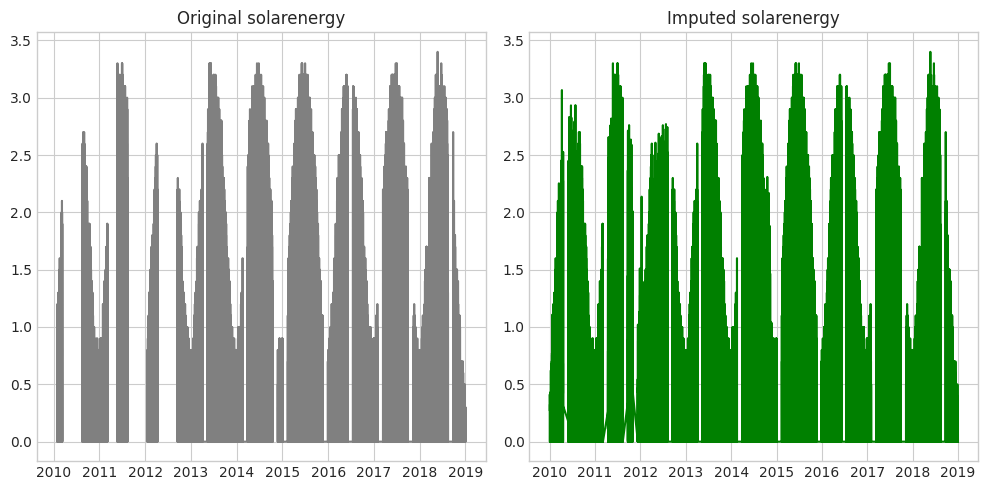

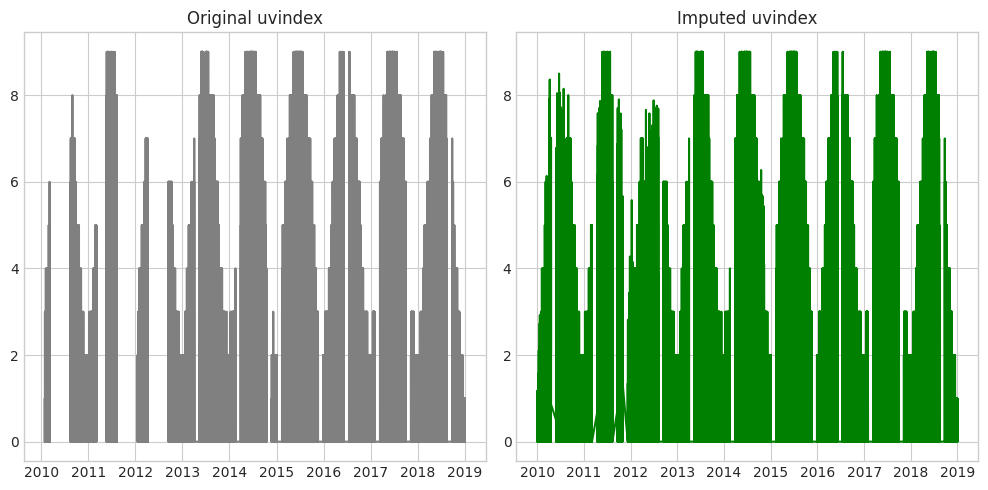

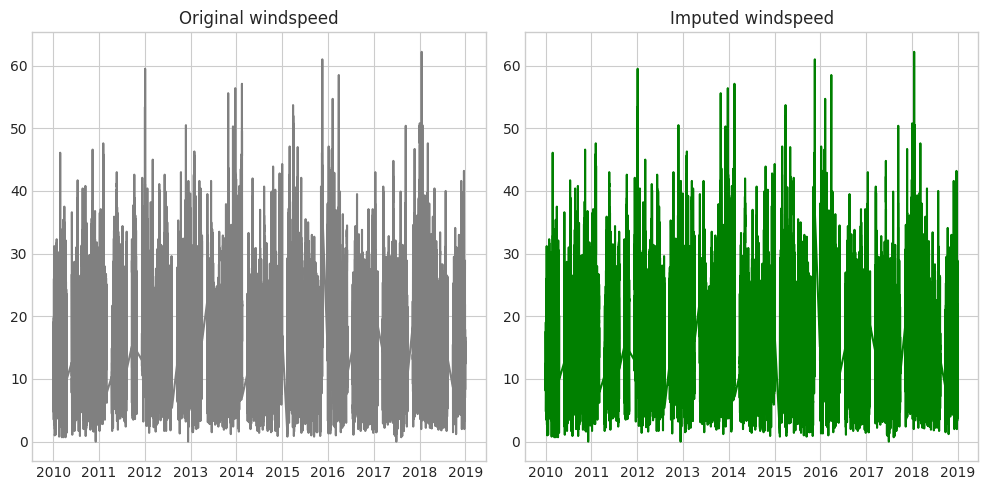

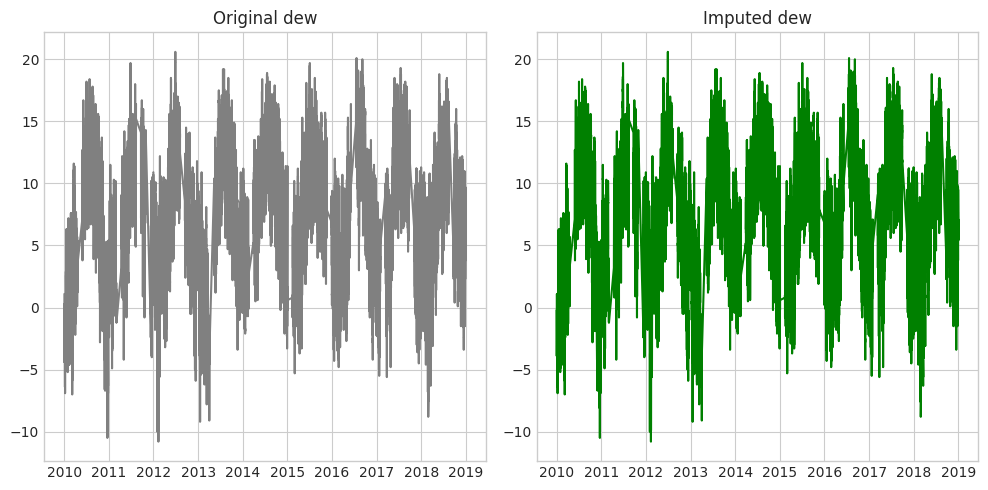

In [66]:
for cols in df.isnull().sum().index:
    plot_original_vs_imputed(df[cols],train_data_original[cols],feature1_title=f"Original {cols}",feature2_title=f"Imputed {cols}")

The KNN Imputer has imputed all of the Nulls in the dataset and the dataset looks good to go now

In [70]:
train_data_original["solarenergy"].min(),train_data_original["solarenergy"].max()

(0.0, 3.4)

# Feature Engineering

### Creating Lag Features

By creating lag features, one can record a variable's previous values at various points in time. In essence, these lag features are duplicates of the variable that have been moved in time. 

In [29]:
def create_lag_features(data,lag_steps=1):
    data = data.copy()
    for target in data.columns:
        data[f'{target}_lag_{lag_steps}'] = data[target].shift(lag_steps)
        
    return data

Creating Lag Features for every column so that the temporal dependency or patterns is captured in the data. Here we have specifically used 24 hours lag. This lag is choosen upon multiple experiments. This lag step value performed better than other.

In [30]:
train_data = create_lag_features(train_data_original,lag_steps=24)
validation_data = create_lag_features(validation_data_original,lag_steps=24)
test_data = create_lag_features(test_data_original,lag_steps=24)

### Imputing Nulls Created by Lags

When we are creating lags it creates some lags so we will impute them. We will use bfill method as we want to retain the temporal dependencies.

In [31]:

def fill_na_values(train,val,test,method):
	train_lagged = train.fillna(method=method)
	validation_lagged = val.fillna(method=method)
	test_lagged = test.fillna(method=method)

	return train_lagged,validation_lagged,test_lagged

In [32]:
train_data,validation_data,test_data = fill_na_values(train_data,validation_data,test_data,method="bfill")

In [75]:
train_data.head()

,temp,humidity,cloudcover,solarradiation,solarenergy,uvindex,windspeed,dew,temp_lag_24,humidity_lag_24,cloudcover_lag_24,solarradiation_lag_24,solarenergy_lag_24,uvindex_lag_24,windspeed_lag_24,dew_lag_24
datetime,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,0.5,95.56,28.9,0.000000,0.000000,0.000000,19.0,-0.2,0.5,95.56,28.9,0.0,0.0,0.0,19.0,-0.2
2010-01-01 01:00:00,0.3,93.41,33.8,10.041884,0.029329,0.000000,13.5,-0.6,0.5,95.56,28.9,0.0,0.0,0.0,19.0,-0.2
2010-01-01 02:00:00,0.2,92.79,42.1,24.843409,0.077228,0.199107,14.3,-0.8,0.5,95.56,28.9,0.0,0.0,0.0,19.0,-0.2
2010-01-01 03:00:00,-0.1,95.73,68.5,19.704848,0.061835,0.206118,11.4,-0.7,0.5,95.56,28.9,0.0,0.0,0.0,19.0,-0.2
2010-01-01 04:00:00,-1.2,95.70,19.2,113.108488,0.411872,1.176533,13.6,-1.8,0.5,95.56,28.9,0.0,0.0,0.0,19.0,-0.2


# Choosing Threshold for Solarenergy

Let us assume:

    1. The data we have has solarenergy units in MJ/m2. We will assume each solar panel is 1 square meter. So we will consider we have  1,000 panels which is in working condition and each of one square meter.

    
    2. when there will be solar energy sulprus we will provide free electricity to 500 houses of colchester.

    
    3. according to the research, in 2021 the average houses of colchester consumed around 2,837 kWh of electricity when the electricity was not free. -> Link ->https://www.gazette-news.co.uk/news/23243345.colchester-households-paying-twice-much-last-winter-energy/
    
    
    For simplicity we will assume an average house consumes 3,000Kwh of electricity in a year when the electricity is not free.

        Lets convert the year consumption into an hour consumption. So we will have to divide 3000 by (24*365) each day of 24 hour so for a year it would be (24*365)
        
        This means average power consumption by a house per hour = 3000Kwh/(24*365)hours = 0.3425kW

        If free electricity is to be provided the consumption is likely to increase because people would consume alot of electricity since its free. So lets say electricity consumption increase by 40% in an hour when electricity is free:

         - Increase in consumption = (0.3425 * 0.40) = 0.137,

        So, average house would consume = 0.3425kW + 0.137kW = 0.4795 


        Finally if we want to provide free electricity to 100 houses, then according to above assumptions solar panels should produce more than = 0.4795 * 500 houses = 239.75kW of electricity. to provide them for free.


So our threshold becomes = 239.75kW

The solar energy units provided in our dataset is MJ/m2 according to the documentation. 

     - If we consider we have 1000 panels each of which is 1 m2.

     then,

     1. Total area = number of panels * area per panel

                = 1000 panels * 1 square meter/ panel
                = 1000 square meters

    2. Calculate total energy generated in MegaJoules over the hour:
         = total energy In MJ = solar energy produced * total area = solar energy MJ/m2 * 1000 m2

    3. Converting MJ to Kw
         total power in KW = Total energy in MJ/ Time(in hour)

         so, for each hour total power in KW = Total energy in MJ/1 = total energy in MJ
    


In [33]:
THRESHOLD_FOR_500_HOUSES_IN_KW = 239.75

### Converting Solar Energy From MJ/m2 to KW

In [34]:
def convert_solar_to_kw(solar_energy,number_of_panels=1000,area_per_panel=1,one_mj= 0.2777777778):

    """

    This function takes solar energy value, number of panels, the panels covered by each panel, and one MJ value.

    And this function converts a solar energy from MJ/m2 to KW
    
    """

    area = number_of_panels * area_per_panel
    
    total_energy_in_mj = solar_energy *  area

    # converts MegaJoule to KWh
    mj_to_kw = total_energy_in_mj * one_mj

    # converts kwh to one hour
    kwh_to_kw = mj_to_kw / 1

    return kwh_to_kw
    

In [ ]:
train_data["solarenergy"].values

array([0.        , 0.0293295 , 0.07722781, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
solar_energy = train_data["solarenergy"].apply(lambda x: convert_solar_to_kw(x,number_of_panels=1000,area_per_panel=1,one_mj= 0.2777777778))

In [79]:
solar_energy

datetime
2010-01-01 00:00:00      0.000000
2010-01-01 01:00:00      8.147083
2010-01-01 02:00:00     21.452168
2010-01-01 03:00:00     17.176472
2010-01-01 04:00:00    114.408824
                          ...    
2018-12-31 19:00:00      0.000000
2018-12-31 20:00:00      0.000000
2018-12-31 21:00:00      0.000000
2018-12-31 22:00:00      0.000000
2018-12-31 23:00:00      0.000000
Name: solarenergy, Length: 66408, dtype: float64

# Model Building

### Data Standardization

standardizing the data since every feature in the data is in different units. 

In [35]:
def standardize_data(X,dataset_type,scaler=None):

    if dataset_type == "train":
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        return X,scaler
    else:
        X = scaler.transform(X)
        return X


In [36]:
train_data_trf,scaler = standardize_data(X=train_data.drop("solarenergy",axis=1).values,dataset_type="train",scaler=None)
validation_data_trf = standardize_data(X=validation_data.drop("solarenergy",axis=1).values,dataset_type="val",scaler=scaler)
test_data_trf = standardize_data(X=test_data.drop("solarenergy",axis=1).values,dataset_type="test",scaler=scaler)

### Preparing Data For for Training

In [43]:
# four days of previous data
window_size_x = 24*4

# 24 hour future data
window_size_y = 24

We will use siding window to slide through the data. For this 96 previous hour data has been used as feature and 96 + 24 has been used as a label. This is slided through each row.

In [49]:

def prepare_data(window_size_x,window_size_y,X, y):

    trainX = []
    trainY = []

    # To be in bounds of the data we have subtracted total row of data - window size of x - window size of y
    for idx in range(X.shape[0] - window_size_x - window_size_y + 1):
        trainX.append(X[idx:idx + window_size_x, :])
        trainY.append(y[idx:idx + window_size_x + window_size_y])

    # converted the data to numpy array
    final_data = np.array(trainX)
    final_label = np.array(trainY)
    
    return final_data, final_label

In [50]:

final_train_data,final_train_label = prepare_data(window_size_x,window_size_y,X=train_data_trf, y=train_data["solarenergy"].values)

final_validation_data,final_validation_label = prepare_data(window_size_x,window_size_y,X=validation_data_trf, y=validation_data["solarenergy"].values)

final_test_data,final_test_label = prepare_data(window_size_x,window_size_y,X=test_data_trf, y=test_data["solarenergy"].values)

In [51]:
final_train_data.shape,final_train_label.shape

((66289, 96, 15), (66289, 120))

### Metrics

In [201]:
def calculate_metrics(y_test,y_pred):
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    
    print("\n")
    print("----------------------------------------------------------------------------------------------")
    print("MAE",mean_absolute_error(y_test,y_pred))
    print("MSE",mean_squared_error(y_test,y_pred))
    print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
    print("----------------------------------------------------------------------------------------------")
    return mae,mse,rmse

### Naive Model

For the naive model we will assume that the model exactly behaves same as previous years. So, here in our case we are just assuming that the test data we have will behave same as validation data which is the data form previous years.

In [207]:
def naive_model(validation_data,test_data,validation_label,test_label,validation_data_with_index):

    # here we are taking the last value so that we are predicting 24 hours in advance.
    actual_label = validation_label[:,-1]

    # here we are restricting our value to actual_label shape because our test data is of 3 years and validation is of two years.
    # and we are taking last value from our window size.So which means we are predicting 24 hours in advance
    prediction_label = test_label[:actual_label.shape[0],-1]

    naive_df = pd.DataFrame({"Actual Naive Label":actual_label,"Predicted Naive Label":prediction_label})

    # converting to kw
    naive_df["Actual Naive Label (KW)"] = naive_df["Actual Naive Label"].apply(lambda x: convert_solar_to_kw(x,number_of_panels=1000,area_per_panel=1,one_mj= 0.2777777778))
    naive_df["Predicted Naive Label (KW)"] = naive_df["Predicted Naive Label"].apply(lambda x: convert_solar_to_kw(x,number_of_panels=1000,area_per_panel=1,one_mj= 0.2777777778))

    # adding the index values
    naive_df.index = validation_data_with_index.index[:actual_label.shape[0]]

    return naive_df

naive_df = naive_model(final_validation_data,final_test_data,final_validation_label,final_test_label,validation_data_with_index=validation_data)
naive_df

,Actual Naive Label,Predicted Naive Label,Actual Naive Label (KW),Predicted Naive Label (KW)
datetime,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.0
2019-01-01 01:00:00,0.0,0.0,0.0,0.0
2019-01-01 02:00:00,0.0,0.0,0.0,0.0
2019-01-01 03:00:00,0.0,0.0,0.0,0.0
2019-01-01 04:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2020-12-26 20:00:00,0.0,0.0,0.0,0.0
2020-12-26 21:00:00,0.0,0.0,0.0,0.0
2020-12-26 22:00:00,0.0,0.0,0.0,0.0


In [208]:
calculate_metrics(naive_df["Actual Naive Label (KW)"],naive_df["Predicted Naive Label (KW)"])



----------------------------------------------------------------------------------------------
MAE 67.56924792180327
MSE 18115.09698984832
RMSE 134.5923362968647
----------------------------------------------------------------------------------------------


(67.56924792180327, 18115.09698984832, 134.5923362968647)

### LSTM

Why have I particularly chosen LSTM is because LSTM perfomed well on the dataset. I tried with other simple RNN and other methods but this seems to work well. And this model is tuned by analyzing the error on the dataset.

LSTM is well known to remember the temporal dependencies of the data. Here we have used RMSProp as adam and other optimizers performed not too well.


This model will output 120 values out of which we only need last 24 values which is our forcasted values.


In [46]:
train_model_epoch = 20

In [47]:
def train_model(train_data,train_label,val_data,val_label,window_size_x,window_size_y,epochs=1,early_stopping_patience=3):
	
	model = Sequential()
	model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], train_data.shape[2])))
	model.add(LSTM(units=50,recurrent_dropout=0.1))
	model.add(Dense(units=window_size_x+window_size_y))
	model.summary()
	
	callbacks = [EarlyStopping(monitor='val_mean_absolute_error', patience=early_stopping_patience)]
	model.compile(optimizer="rmsprop",loss="mse",metrics=["mean_absolute_error"])
	model.fit(train_data,train_label, validation_data=(val_data,val_label), epochs=epochs, batch_size=32,callbacks=callbacks)

	return model

In [233]:
model = train_model(final_train_data,final_train_label,final_validation_data,final_validation_label,window_size_x,window_size_y,early_stopping_patience=3,epochs=train_model_epoch)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 96, 50)         │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 120)            │         6,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,520 (154.38 KB)

 Trainable params: 39,520 (154.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 114s 54ms/step - loss: 0.1637 - mean_absolute_error: 0.2571 - val_loss: 0.0589 - val_mean_absolute_error: 0.1467
Epoch 2/20
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 111s 54ms/step - loss: 0.0645 - mean_absolute_error: 0.1618 - val_loss: 0.0469 - val_mean_absolute_error: 0.1287
Epoch 3/20
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 110s 53ms/step - loss: 0.0545 - mean_absolute_error: 0.1434 - val_loss: 0.0423 - val_mean_absolute_error: 0.1210
Epoch 4/20
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 110s 53ms/step - loss: 0.0498 - mean_absolute_error: 0.1338 - val_loss: 0.0409 - val_mean_absolute_error: 0.1171
Epoch 5/20
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 107s 52ms/step - loss: 0.0475 - mean_absolute_error: 0.1293 - val_loss: 0.0390 - val_mean_absolute_error: 0.1134
Epoch 6/20
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 110s 53ms/step - loss: 0.0453 - mean_absolute_error: 0.1252 - val_loss: 0.0397 - val_mean_absolute_error: 0.1150
Epoch 7/20
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 111s 53ms/step - loss: 0.043

In [234]:
model.history.history

{'loss': [0.10149109363555908,
  0.06093146651983261,
  0.05329187586903572,
  0.04910693317651749,
  0.04650229215621948,
  0.04469694197177887,
  0.0432559996843338,
  0.04209119826555252,
  0.04106466472148895,
  0.04012118652462959,
  0.039203573018312454,
  0.03816089406609535,
  0.03712443634867668,
  0.036121249198913574],
 'mean_absolute_error': [0.204932302236557,
  0.15594497323036194,
  0.14071068167686462,
  0.13249747455120087,
  0.1275436282157898,
  0.1240132749080658,
  0.12140635401010513,
  0.11927402019500732,
  0.1174946129322052,
  0.11596161127090454,
  0.11470411717891693,
  0.11345140635967255,
  0.11221485584974289,
  0.11096026003360748],
 'val_loss': [0.05889808386564255,
  0.046940382570028305,
  0.04227244481444359,
  0.040918007493019104,
  0.03897137567400932,
  0.03966484218835831,
  0.03828584775328636,
  0.03731927275657654,
  0.03803999349474907,
  0.03807070478796959,
  0.0366511270403862,
  0.037760477513074875,
  0.03863946348428726,
  0.0382790416

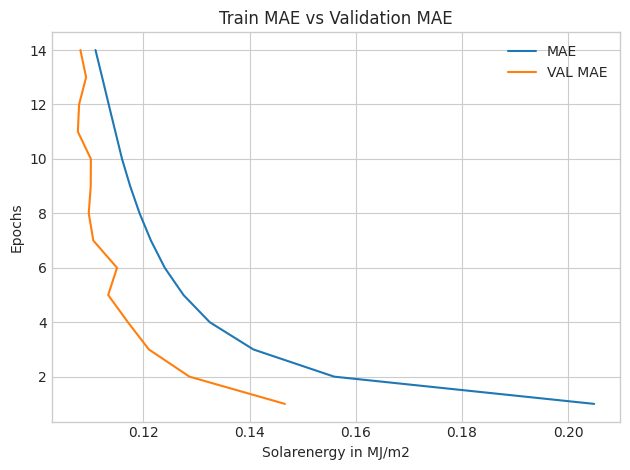

In [242]:
plt.plot(model.history.history["mean_absolute_error"],np.arange(1,15,1),label="MAE")
plt.plot(model.history.history["val_mean_absolute_error"],np.arange(1,15,1),label="VAL MAE")
plt.xlabel("Solarenergy in MJ/m2")
plt.ylabel("Epochs")
plt.title("Train MAE vs Validation MAE")
plt.legend()
plt.tight_layout()
plt.show()

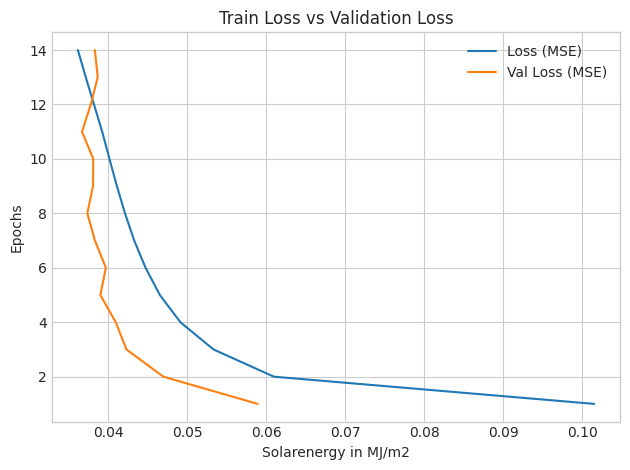

In [241]:
plt.plot(model.history.history["loss"],np.arange(1,15,1),label="Loss (MSE)")
plt.plot(model.history.history["val_loss"],np.arange(1,15,1),label="Val Loss (MSE)")
plt.xlabel("Solarenergy in MJ/m2")
plt.ylabel("Epochs")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

Both MAE and MSE seems to be decreasing which is good for our model.

### Prediction on test

In [246]:
test_prediction = model.predict(final_test_data)
final_test_prediction = np.clip(test_prediction,0,test_prediction.max())

689/689 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


In [111]:
calculate_metrics(final_test_label,final_test_prediction)



----------------------------------------------------------------------------------------------
MAE 0.11902754948798774
MSE 0.055364280832450416
RMSE 0.23529615558366102
----------------------------------------------------------------------------------------------


(0.11902754948798774, 0.055364280832450416, 0.23529615558366102)

### Converting predictions to dataframe to visualize

In the below cell. The predictions and actual values has been converted into KW.

In [247]:
def prediction_and_actual_dataframe(test_data_original,final_test_data,final_test_prediction,window_size_x,window_size_y):

    # we are subtracting the rows because the data which is prepared for training will have window size of (window_size_x+window_size_y)
    # so to not be out of bounds we subtract this.
    test_upto = test_data_original.shape[0]-final_test_data.shape[0]

    
    test_pred_and_actual_df = pd.DataFrame({
        # actual solarenergy of test data.
        "Actual": test_data_original["solarenergy"].values[:-test_upto],

        # predition of our model. here we are clipping our values between 0 to max value of prediction.
        # we are clipping our values because model was predicting negative value which does not make sense in terms of solarenergy.
        "Prediction":np.clip(final_test_prediction[:,-1],0,final_test_prediction[:,-1].max())

        # indexing the dataframe from original test data for visualization
    },index=test_data_original.index[:-test_upto])


    # converting actual and predicted solarenergy from MJ/m2 to KW.
    test_pred_and_actual_df["Actual"] = test_pred_and_actual_df["Actual"].apply(lambda x: convert_solar_to_kw(x,number_of_panels=1000,area_per_panel=1,one_mj= 0.2777777778))
    test_pred_and_actual_df["Prediction"] = test_pred_and_actual_df["Prediction"].apply(lambda x: convert_solar_to_kw(x,number_of_panels=1000,area_per_panel=1,one_mj= 0.2777777778))

    # absolute difference just for the observation.
    test_pred_and_actual_df["abs_difference"] = abs(test_pred_and_actual_df["Actual"] - test_pred_and_actual_df["Prediction"])

    # saving the dataframe
    test_pred_and_actual_df.to_csv(f"../dataset/actual_test_data_and_test_prediction_{window_size_x}_{window_size_y}.csv",index=False)
    
    return test_pred_and_actual_df


In [248]:
test_pred_and_actual_df = prediction_and_actual_dataframe(test_data_original,final_test_data,final_test_prediction,window_size_x,window_size_y)

In [249]:
# test_pred_and_actual_df = pd.read_csv("actual_test_data_and_test_prediction_96_24.csv")
test_pred_and_actual_df

,Actual,Prediction,abs_difference
datetime,,,
2021-01-01 00:00:00,0.000000,8.331007,8.331007
2021-01-01 01:00:00,0.000000,7.934820,7.934820
2021-01-01 02:00:00,0.000000,8.991837,8.991837
2021-01-01 03:00:00,0.000000,9.174813,9.174813
2021-01-01 04:00:00,0.000000,9.581945,9.581945
...,...,...,...
2023-12-31 06:00:00,0.000000,0.000000,0.000000
2023-12-31 07:00:00,0.000000,0.200882,0.200882
2023-12-31 08:00:00,0.000000,1.766946,1.766946


In [81]:
test_pred_and_actual_df = pd.read_csv("actual_test_data_and_test_prediction_96_24.csv")
test_pred_and_actual_df

,Actual,Prediction,abs_difference
0,0.000000,8.331007,8.331007
1,0.000000,7.934820,7.934820
2,0.000000,8.991837,8.991837
3,0.000000,9.174813,9.174813
4,0.000000,9.581945,9.581945
...,...,...,...
22014,0.000000,0.000000,0.000000
22015,0.000000,0.200882,0.200882
22016,0.000000,1.766946,1.766946
22017,27.777778,5.471519,22.306259


In [250]:
MAE_in_KW, MSE_in_KW, RMSE_in_KW = calculate_metrics(test_pred_and_actual_df["Actual"],test_pred_and_actual_df["Prediction"])



----------------------------------------------------------------------------------------------
MAE 64.27321751085289
MSE 12305.507239907372
RMSE 110.93019084048929
----------------------------------------------------------------------------------------------


In [251]:
MAE_in_KW

64.27321751085289

### False Positives for initial threshold

In [82]:
condition = (test_pred_and_actual_df["Prediction"] > THRESHOLD_FOR_500_HOUSES_IN_KW)
test_pred_and_actual_df["initial_threshold"] = np.where(condition,1,0)

In [87]:
test_pred_and_actual_df[test_pred_and_actual_df["initial_threshold"] == 1].shape[0]

4663

In [95]:
number_of_time_to_provide_free_electricity_initial_threshold = test_pred_and_actual_df[test_pred_and_actual_df["initial_threshold"] == 1].shape[0]
number_of_time_to_provide_free_electricity_initial_threshold

4663

Here the number of hours to provide free electricity is really high. We will do the same for safe buffer threshold

### Threshold Updation

We will update the threshold. We will take our threshold a little higher such that the company do not loose money. This means we are trying to reduce the false positives.

In [88]:
safe_buffer_threshold = THRESHOLD_FOR_500_HOUSES_IN_KW * 1.5

In [89]:
safe_buffer_threshold

359.625

### False positives for safe buffer threshold

In [90]:
condition = (test_pred_and_actual_df["Prediction"] > safe_buffer_threshold)
test_pred_and_actual_df["safe_buffer_threshold"] = np.where(condition,1,0)

In [93]:
number_of_time_to_provide_free_electricity_safe_threshold = test_pred_and_actual_df[test_pred_and_actual_df["safe_buffer_threshold"] == 1].shape[0]
number_of_time_to_provide_free_electricity_safe_threshold

2817

Here the number of hours to provide free electricity has decreased. This proves that our false positive came down

### Forecasting 24 Hours in Advance

In [53]:
def predict(model,last_96_hours_data):
    prediction_120_hours = model.predict(last_96_hours_data)

    last_24_hours_prediction = prediction_120_hours[-24:]

    return last_24_hours_prediction

In [54]:
# taking last 96 hours of data from our test dataset and reshaping according to the need of model.
last_96_hours_data = test_data_trf[-window_size_x:].reshape(1,window_size_x,-1)

In [65]:
# calling the function predict
forecatsed_energy = predict(model,last_96_hours_data)
forecatsed_energy = forecatsed_energy.flatten()

# clipping data between 0 to maximum of prediction to remove negative values
forecatsed_energy = np.clip(forecatsed_energy[-24:],0,forecatsed_energy[-24:].max())

1/1 [==============================] - 0s 47ms/step


In [66]:
forecatsed_energy

array([0.15181074, 0.19103096, 0.25272465, 0.22406818, 0.24732044,
       0.19071417, 0.13581158, 0.12736076, 0.03935606, 0.0068217 ,
       0.        , 0.        , 0.        , 0.        , 0.00202315,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05404082, 0.08855781], dtype=float32)

In [62]:
test_data.tail()

,temp,humidity,cloudcover,solarradiation,solarenergy,uvindex,windspeed,dew,temp_lag_24,humidity_lag_24,cloudcover_lag_24,solarradiation_lag_24,solarenergy_lag_24,uvindex_lag_24,windspeed_lag_24,dew_lag_24
datetime,,,,,,,,,,,,,,,,
2024-01-05 05:00:00,5.2,92.17,100.0,0.0,0.0,0.0,27.6,4.1,7.400000,90.06,86.2,0.0,0.0,0.0,13.7,5.9
2024-01-05 06:00:00,5.2,92.40,96.6,0.0,0.0,0.0,29.6,4.0,4.300000,92.34,83.5,0.0,0.0,0.0,29.3,3.1
2024-01-05 07:00:00,5.5,89.64,95.8,0.0,0.0,0.0,28.1,4.0,6.006727,85.83,82.8,0.0,0.0,0.0,16.3,4.9
2024-01-05 08:00:00,5.8,88.93,91.8,0.0,0.0,0.0,27.9,4.1,5.400000,87.00,31.6,0.0,0.0,0.0,14.9,3.4
2024-01-05 09:00:00,6.0,88.83,92.3,8.0,0.0,0.0,27.5,4.2,5.400000,90.17,31.6,37.0,0.1,0.0,16.0,4.0


### Making DataFrame to Visualize 24 hours in advance forecast

In [71]:
# starting date is the end of our test dataset date and time.
start_date = '2024-01-05 10:00:00'

# end date is the just 24 hours added to start date
end_date = '2024-01-06 09:00:00'

date_range_24_hours = pd.date_range(start=start_date, end=end_date, freq='H')
predicted_last_24 = pd.DataFrame({'Datetime': date_range_24_hours})
predicted_last_24["forecatsed_energy (MJ/m2)"] = forecatsed_energy
predicted_last_24

,Datetime,forecatsed_energy (MJ/m2)
0,2024-01-05 10:00:00,0.151811
1,2024-01-05 11:00:00,0.191031
2,2024-01-05 12:00:00,0.252725
3,2024-01-05 13:00:00,0.224068
4,2024-01-05 14:00:00,0.247320
5,2024-01-05 15:00:00,0.190714
6,2024-01-05 16:00:00,0.135812
7,2024-01-05 17:00:00,0.127361
8,2024-01-05 18:00:00,0.039356
9,2024-01-05 19:00:00,0.006822


In [72]:
# Converting the predictions from MJ/m2 to KW
predicted_last_24["forecatsed_energy (KW)"] = predicted_last_24["forecatsed_energy (MJ/m2)"].apply(lambda x: convert_solar_to_kw(x,number_of_panels=1000,area_per_panel=1,one_mj= 0.2777777778))
predicted_last_24

,Datetime,forecatsed_energy (MJ/m2),forecatsed_energy (KW)
0,2024-01-05 10:00:00,0.151811,42.169649
1,2024-01-05 11:00:00,0.191031,53.064157
2,2024-01-05 12:00:00,0.252725,70.201291
3,2024-01-05 13:00:00,0.224068,62.241161
4,2024-01-05 14:00:00,0.247320,68.700123
5,2024-01-05 15:00:00,0.190714,52.976157
6,2024-01-05 16:00:00,0.135812,37.725440
7,2024-01-05 17:00:00,0.127361,35.377989
8,2024-01-05 18:00:00,0.039356,10.932239
9,2024-01-05 19:00:00,0.006822,1.894915


### Plots

#### Plot For Naive Model

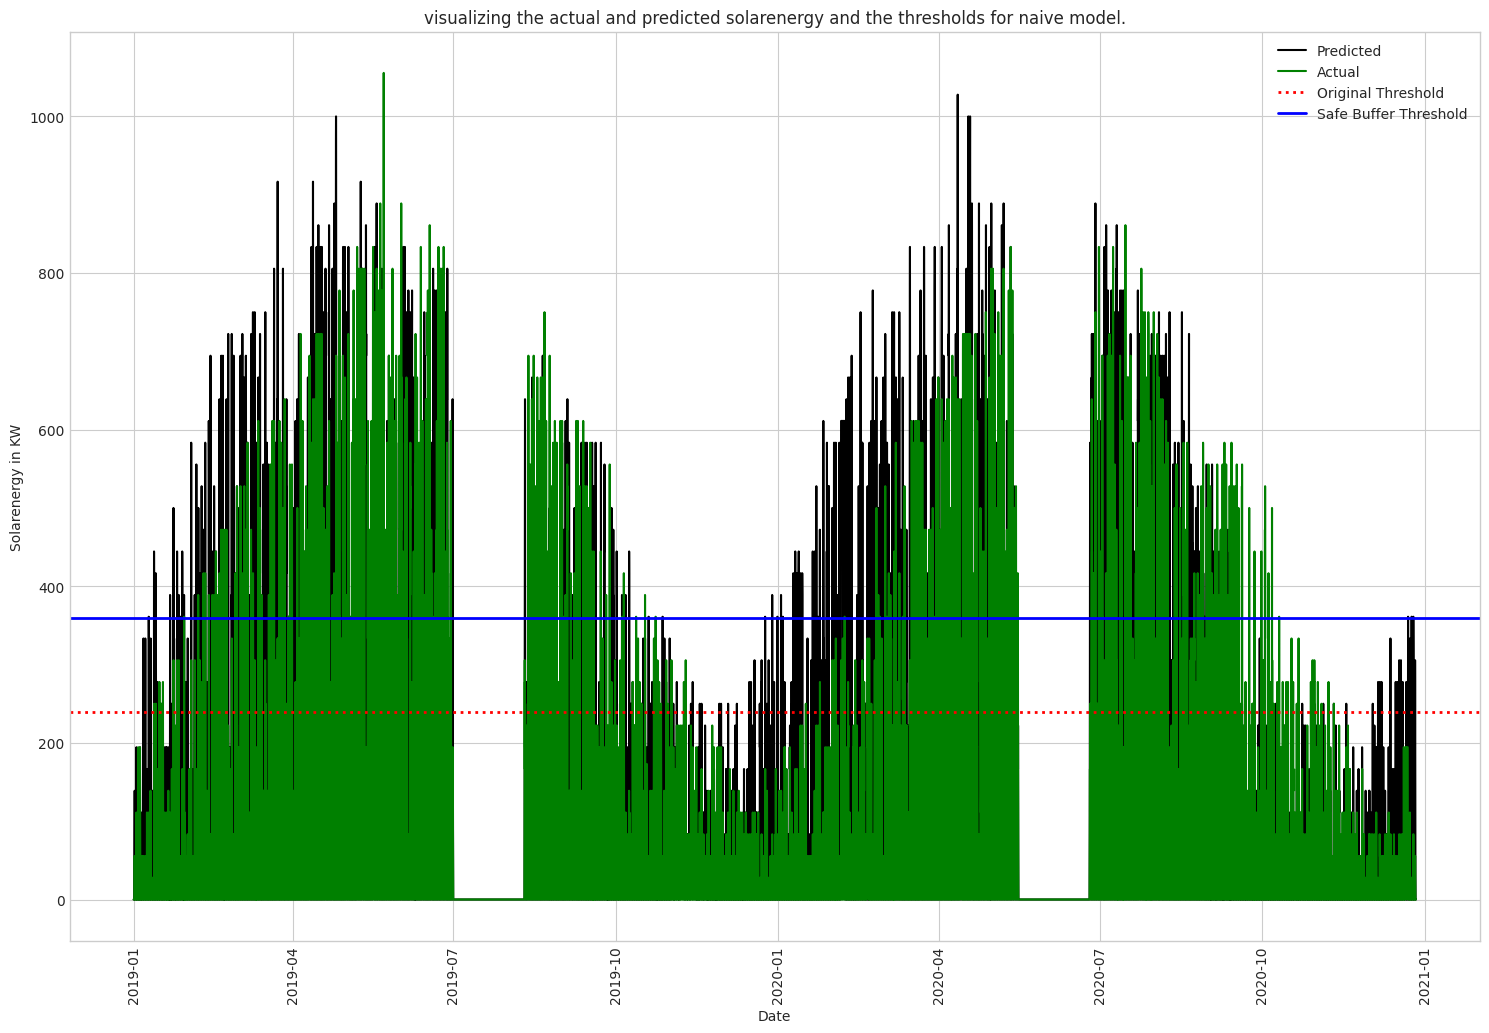

In [258]:
plt.figure(figsize=(15,10))
plt.plot(naive_df["Predicted Naive Label (KW)"],color="black",label="Predicted")
plt.plot(naive_df["Actual Naive Label (KW)"],color="green",label="Actual")


plt.axhline(y=THRESHOLD_FOR_500_HOUSES_IN_KW,color="red",linestyle=":",linewidth=2,label="Original Threshold")
plt.axhline(y=safe_buffer_threshold,color="blue",linestyle="-",linewidth=2,label="Safe Buffer Threshold")

plt.legend()

plt.xlabel("Date")
plt.ylabel("Solarenergy in KW")

plt.title("visualizing the actual and predicted solarenergy and the thresholds for naive model.")

plt.tight_layout()
plt.tick_params(axis='x', rotation=90)
plt.show()

Here we can see that the naive model is peforming okay but not good. As we can see that the actual  values which is in green is less than the predicted value which is in black. So this is what we don't want. We want to reduce the false positives.

#### Plot for LSTM MODEL

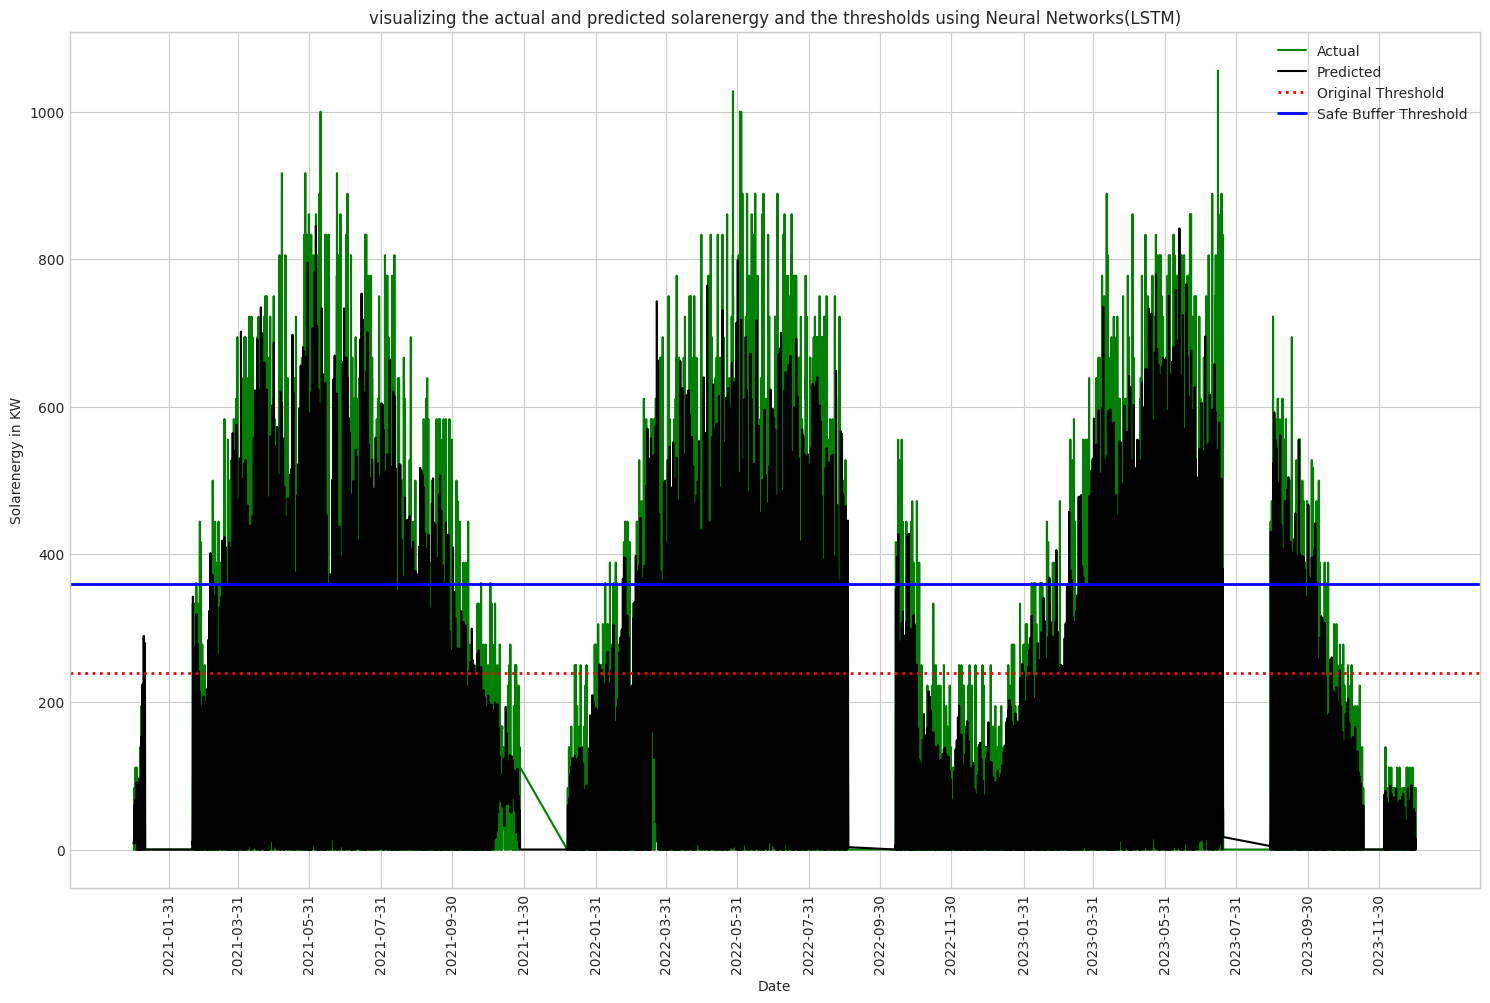

In [257]:
plt.figure(figsize=(15,10))
plt.plot(test_pred_and_actual_df["Actual"],color="green",label="Actual")
plt.plot(test_pred_and_actual_df["Prediction"],color="black",label="Predicted")
plt.xticks(pd.date_range(start='2021-01-01', end='2024-01-10', freq='2M'), rotation=45)

plt.axhline(y=THRESHOLD_FOR_500_HOUSES_IN_KW,color="red",linestyle=":",linewidth=2,label="Original Threshold")
plt.axhline(y=safe_buffer_threshold,color="blue",linestyle="-",linewidth=2,label="Safe Buffer Threshold")

plt.legend()

plt.xlabel("Date")
plt.ylabel("Solarenergy in KW")

plt.title("visualizing the actual and predicted solarenergy and the thresholds using Neural Networks(LSTM)")

plt.tight_layout()
plt.tick_params(axis='x', rotation=90)
plt.show()

Here in the above plot we can see that we have plotted two different values which is actual solar energy and predicted solarenergy. We have two threshold, the red is actual threshold for 500 houses and bule is safe buffer threshold. We will use blue line threshold which is safe buffer threshold so that the false positives go down.

Also we can observe here that the solar energy is majorly sulprus during summer season which is from around April to September and it makes sense because during summer time sunlight remains for a longer period of time in Colchester and solarenergy is produced in sulprus.

In [53]:
test_pred_and_actual_df["Actual"]

datetime
2021-01-01 00:00:00     0.000000
2021-01-01 01:00:00     0.000000
2021-01-01 02:00:00     0.000000
2021-01-01 03:00:00     0.000000
2021-01-01 04:00:00     0.000000
                         ...    
2023-12-31 06:00:00     0.000000
2023-12-31 07:00:00     0.000000
2023-12-31 08:00:00     0.000000
2023-12-31 09:00:00    27.777778
2023-12-31 10:00:00    83.333333
Name: Actual, Length: 22019, dtype: float64

## Moving Average

In [73]:
test_pred_and_actual_df = pd.read_csv("actual_test_data_and_test_prediction_96_24.csv")

In [78]:

# Apply a moving average (smoothing)
window_size = 24*1 #number of hours per window size
rolling_mean_actual = test_pred_and_actual_df["Actual"].rolling(window=window_size).mean()
rolling_mean_predicted = test_pred_and_actual_df["Prediction"].rolling(window=window_size).mean()

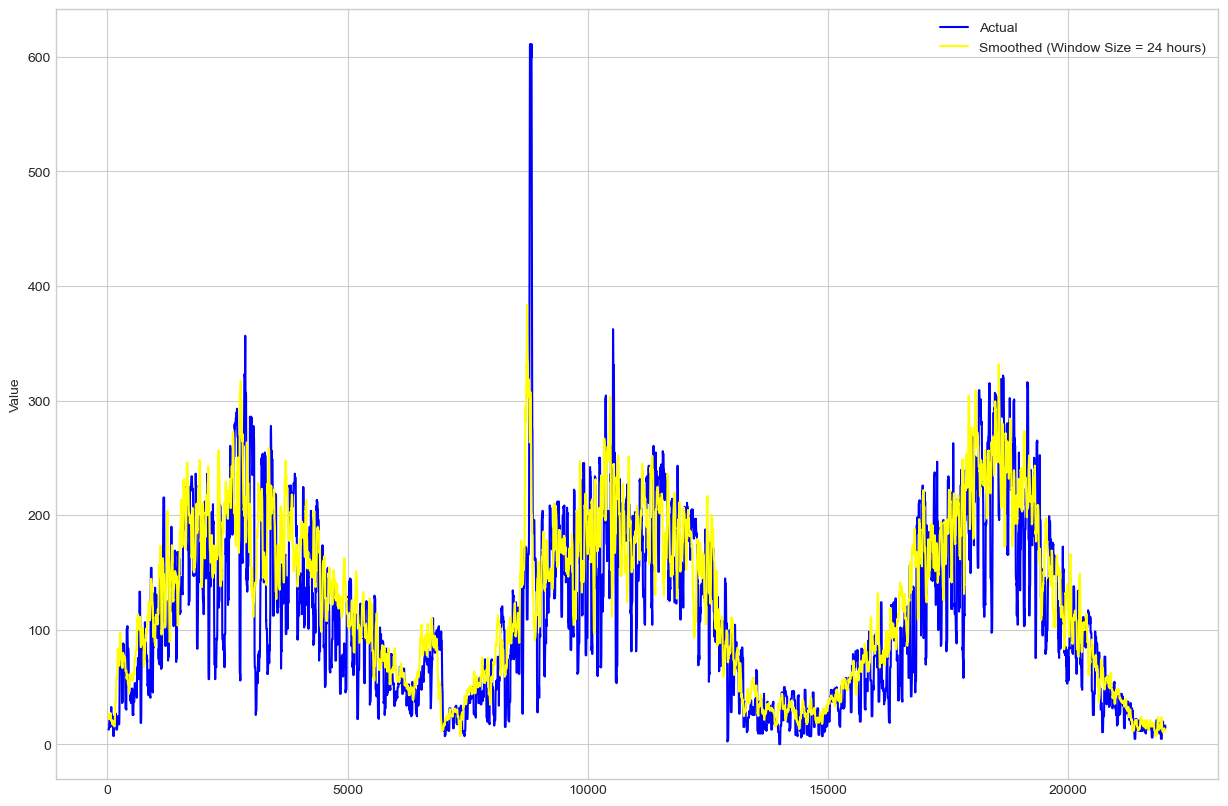

In [79]:

plt.figure(figsize=(15, 10))

rolling_mean_actual.plot(color='blue')
rolling_mean_predicted.plot(color='yellow',label=f'Smoothed (Window Size = {window_size} hours)')

plt.legend()
plt.ylabel('Value')
plt.show()